In [7]:
import pickle
import numpy as np
import pandas as pd

# Load both SHAP result files
with open("code_red_10_shap_results.pkl", "rb") as f1:
    data1 = pickle.load(f1)

with open("slammer_10_shap_results.pkl", "rb") as f2:
    data2 = pickle.load(f2)

# Unpack
shap_values_1 = data1["shap_values"]
X_test_1 = data1["X_test_sample"]
features_1 = data1["feature_names"]

shap_values_2 = data2["shap_values"]
X_test_2 = data2["X_test_sample"]
features_2 = data2["feature_names"]


In [8]:
# Set of all features across both models
all_features = sorted(set(features_1).union(set(features_2)))

In [9]:
def align_shap_vectors(shap_values, feature_names, all_features):
    # Create a mapping from feature name to index in original vector
    name_to_idx = {name: i for i, name in enumerate(feature_names)}
    
    # New aligned SHAP matrix
    aligned = []
    for row in shap_values:
        aligned_row = np.zeros(len(all_features))
        for i, fname in enumerate(all_features):
            if fname in name_to_idx:
                aligned_row[i] = row[name_to_idx[fname]]
        aligned.append(aligned_row)
    return np.array(aligned)

aligned_shap_1 = align_shap_vectors(shap_values_1, features_1, all_features)
aligned_shap_2 = align_shap_vectors(shap_values_2, features_2, all_features)


In [10]:
mean_abs_shap_1 = np.abs(aligned_shap_1).mean(axis=0)
mean_abs_shap_2 = np.abs(aligned_shap_2).mean(axis=0)

df = pd.DataFrame({
    "Feature": all_features,
    "Model 1": mean_abs_shap_1,
    "Model 2": mean_abs_shap_2,
    "Difference": mean_abs_shap_1 - mean_abs_shap_2
})

df.head()

,Feature,Model 1,Model 2,Difference
0,announcements,0.000000,0.000260,-2.601693e-04
1,as_path_max,0.000000,0.000393,-3.929031e-04
2,nlri_ann,0.000666,0.000147,5.196488e-04
3,number_rare_ases,0.000102,0.000102,8.545305e-07
4,origin_changes,0.000101,0.002462,-2.361031e-03


In [11]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_shap_pkl(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return {
        "shap_values": np.array(data["shap_values"]),
        "features": data["feature_names"],
        "X": data["X_test_sample"]
    }

def align_shap_vectors(shap_values, feature_names, all_features):
    name_to_idx = {name: i for i, name in enumerate(feature_names)}
    aligned = np.zeros((len(shap_values), len(all_features)))
    for i, fname in enumerate(all_features):
        if fname in name_to_idx:
            aligned[:, i] = shap_values[:, name_to_idx[fname]]
    return aligned

def compare_shap_files(file1, file2, label1="Model 1", label2="Model 2", top_n=10):
    # Load both SHAP result files
    data1 = load_shap_pkl(file1)
    data2 = load_shap_pkl(file2)

    # Union of features
    all_features = sorted(set(data1["features"]).union(set(data2["features"])))

    # Align SHAP values
    shap1_aligned = align_shap_vectors(data1["shap_values"], data1["features"], all_features)
    shap2_aligned = align_shap_vectors(data2["shap_values"], data2["features"], all_features)

    # Mean absolute SHAP values per feature
    shap1_mean = np.abs(shap1_aligned).mean(axis=0)
    shap2_mean = np.abs(shap2_aligned).mean(axis=0)

    # DataFrame summary
    df = pd.DataFrame({
        "Feature": all_features,
        label1: shap1_mean,
        label2: shap2_mean,
        "Difference": shap1_mean - shap2_mean
    }).sort_values(by="Difference", key=np.abs, ascending=False)

    # Print top 5 features with biggest differences
    print("\nTop differing features:")
    print(df.head(5).to_string(index=False))

    # Bar plot
    df_top = df.head(top_n)
    x = np.arange(top_n)
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, df_top[label1], width, label=label1)
    plt.bar(x + width/2, df_top[label2], width, label=label2)
    plt.xticks(x, df_top["Feature"], rotation=45)
    plt.ylabel("Mean |SHAP value|")
    plt.title("Top Feature Attribution Differences")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df  # In case you want to explore it further


Top differing features:
      Feature  Code Red Model  Slammer Model  Difference
 ratio_exp_wd        0.143968       0.000000    0.143968
rare_ases_avg        0.023585       0.153836   -0.130252
   ratio_dups        0.088691       0.008476    0.080215
  ratio_flaps        0.082408       0.015437    0.066972
   ratio_news        0.000000       0.054546   -0.054546


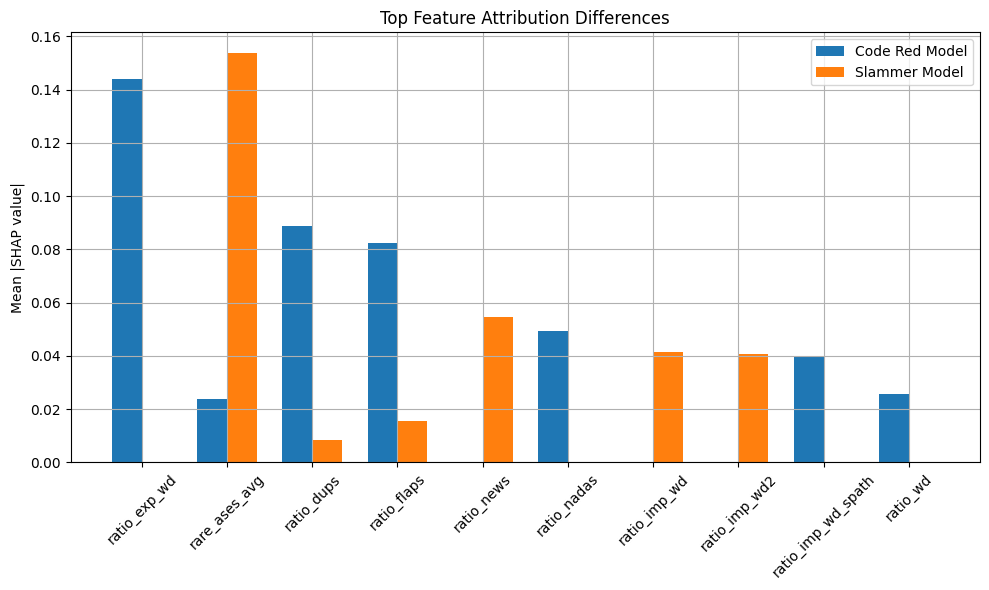

,Feature,Code Red Model,Slammer Model,Difference
8,ratio_exp_wd,0.143968,0.000000,1.439681e-01
5,rare_ases_avg,0.023585,0.153836,-1.302518e-01
7,ratio_dups,0.088691,0.008476,8.021488e-02
9,ratio_flaps,0.082408,0.015437,6.697177e-02
14,ratio_news,0.000000,0.054546,-5.454588e-02
13,ratio_nadas,0.049423,0.000000,4.942304e-02
10,ratio_imp_wd,0.000000,0.041589,-4.158850e-02
11,ratio_imp_wd2,0.000000,0.040602,-4.060215e-02
12,ratio_imp_wd_spath,0.039485,0.000000,3.948536e-02
18,ratio_wd,0.025489,0.000000,2.548863e-02


In [12]:
compare_shap_files(
    "code_red_10_shap_results.pkl",
    "slammer_10_shap_results.pkl",
    label1="Code Red Model",
    label2="Slammer Model"
)
